In [ ]:
from google.colab import drive
# Mount Google Drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import glob
import tensorflow as tf
from keras.applications import InceptionV3,ResNet50
from keras.applications.xception import Xception, preprocess_input
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.optimizers import Adam
from sklearn import preprocessing
from sklearn import metrics


In [ ]:
train_path = '/content/gdrive/MyDrive/data/train'
valid_path = '/content/gdrive/MyDrive/data/test'

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale = 1./255)



training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(valid_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 3229 images belonging to 5 classes.
Found 361 images belonging to 5 classes.


In [ ]:
test_labels = []
for directory_path in glob.glob("/content/gdrive/MyDrive/data/test/*"):
    test_label = directory_path.split("/")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        test_labels.append(test_label)

In [ ]:
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)

In [ ]:
resnet_model = Sequential()

pretrained_model= ResNet50(include_top=False,
                   input_shape=(224,224,3),
                   pooling='avg',
                   classes=5,
                   weights="imagenet")

for layer in resnet_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dropout(0.2))
resnet_model.add(Dense(5, activation='softmax'))

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
resnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               1049088   
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 24639365 (93.99 MB)
Trainable params: 24586245 (93.79 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [ ]:
from keras.callbacks import ReduceLROnPlateau,ModelCheckpoint
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5,
                                  verbose=2,factor=0.2, min_lr=1e-7)

# Checkpoint
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=2, save_best_only=True, mode='max')

In [ ]:
resnet_model.compile(optimizer=Adam(learning_rate=0.001),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

In [ ]:
epochs=30
history = resnet_model.fit(
  training_set,
  validation_data=test_set,
  steps_per_epoch=20,
  epochs=epochs
)

Epoch 1/30
20/20 [==============================] - 57s 953ms/step - loss: 1.6891 - accuracy: 0.5844 - val_loss: 11118301.0000 - val_accuracy: 0.2742
Epoch 2/30
20/20 [==============================] - 17s 840ms/step - loss: 1.0986 - accuracy: 0.6250 - val_loss: 6258801.0000 - val_accuracy: 0.4958
Epoch 3/30
20/20 [==============================] - 20s 974ms/step - loss: 1.1094 - accuracy: 0.6766 - val_loss: 2883251.0000 - val_accuracy: 0.4958
Epoch 4/30
20/20 [==============================] - 19s 936ms/step - loss: 0.9225 - accuracy: 0.6578 - val_loss: 259775.1406 - val_accuracy: 0.4958
Epoch 5/30
20/20 [==============================] - 19s 940ms/step - loss: 1.0250 - accuracy: 0.6484 - val_loss: 340556.1875 - val_accuracy: 0.4958
Epoch 6/30
20/20 [==============================] - 17s 836ms/step - loss: 0.9451 - accuracy: 0.6766 - val_loss: 1520863.0000 - val_accuracy: 0.4958
Epoch 7/30
20/20 [==============================] - 18s 858ms/step - loss: 1.0005 - accuracy: 0.6687 - val_

In [ ]:
prediction = resnet_model.predict(test_set)
return_val=np.argmax(prediction,axis=1)
print(return_val)

12/12 [==============================] - 3s 172ms/step
[1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 2 1 2 2 1 2 1 2 1 1 1 2 2 1 1 1 2 1 2 1 1 1
 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 1 1 1 2 2 1 2 2 2 1 1 1 1 1 1 1 2
 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 2 1 2 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 2
 1 1 1 2 2 1 2 1 1 2 1 1 1 1 2 2 1 1 1 1 1 1 1 2 1 1 1 1 1 2 1 1 1 2 1 2 2
 1 1 1 2 1 2 1 2 2 2 1 1 1 2 1 1 1 1 2 1 1 1 1 1 1 2 1 1 2 2 1 1 1 1 1 1 1
 2 1 1 1 1 1 1 1 2 1 1 1 1 2 2 1 1 1 1 1 1 1 2 1 1 1 1 2 1 1 1 1 1 1 1 1 1
 1 2 1 1 1 2 1 2 2 1 1 1 1 1 1 2 1 1 2 2 1 1 1 1 1 1 1 1 2 1 2 1 1 1 1 1 1
 1 1 1 2 1 1 1 1 1 2 1 1 2 2 1 1 2 1 1 2 1 1 1 1 1 2 1 1 1 2 2 1 1 2 2 1 1
 1 2 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 2 1 1
 2 1 1 1 2 1 1 2 1 1 2 2 2 1 1 2 1 1 1 1 1 1 1 2 1 1 1 1]


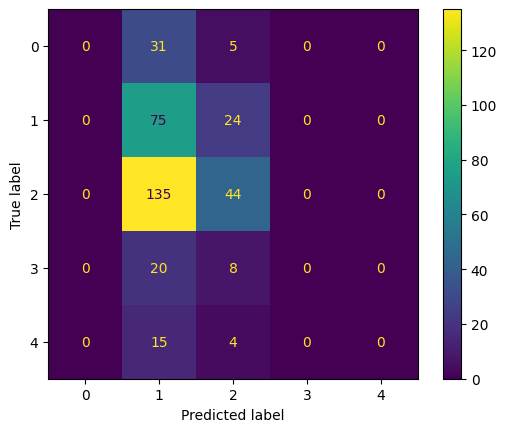

In [ ]:
confusion_matrix = metrics.confusion_matrix(test_labels_encoded, return_val)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0,1,2,3,4])
cm_display.plot()
plt.show()

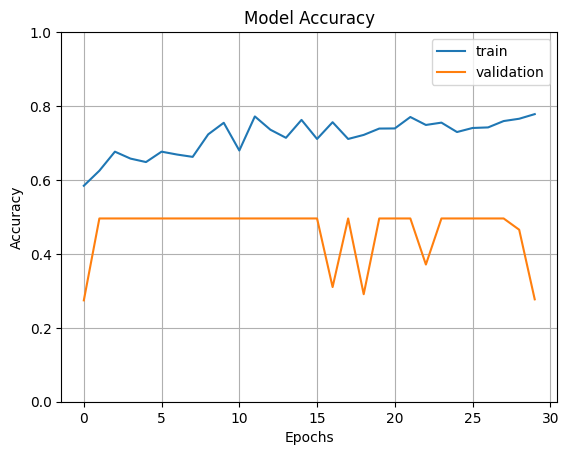

In [ ]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

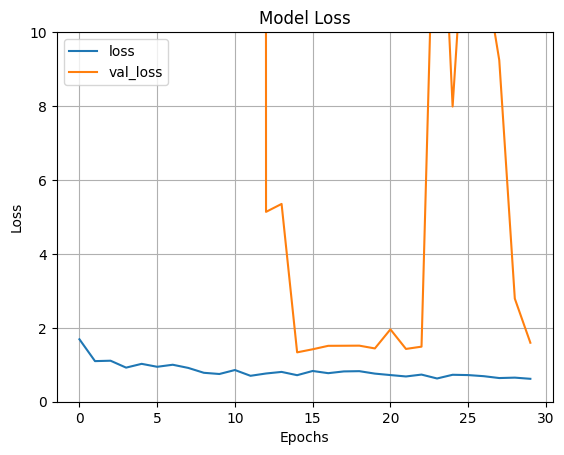

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.axis(ymin=0,ymax=10)
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['loss','val_loss'])
plt.show()